In [1]:
%matplotlib inline
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
import math
import random
from scipy import optimize as op
from random import randint
from itertools import combinations

In [159]:
# HW 5 Index analyses
# Computes Gain info
def get_info_D(n, feature):
    info_D = 0
    feature_counts = Counter(feature)
    for val in feature_counts:
        p_i = feature_counts[val]/n
        info_D -= p_i*math.log(p_i, 2)
    return info_D

# Computes Gini value
def get_gini_D(n, feature):
    gini_D = 1
    feature_counts = Counter(feature)
    for val in feature_counts:
        p_i = feature_counts[val]/n
        gini_D -= math.pow(p_i, 2)
    return gini_D

# Returns info gains, feature split info, and gini indicies
def get_info_gains(n, df):
    # Info(D) and Gini(D)
    class_data = df[df.columns[-1]]
    info_D = get_info_D(n, class_data)
    gini_D = get_gini_D(n, class_data)
    
    # Info_class(D), Split_Info(D), and Gini_class(D)
    feature_info_gain = []
    feature_split_info = []
    feature_gini_indicies = []
    
    # Loop over attributes
    for i in range(len(df.columns)-1):
        # Create summation bases
        feature_info = 0
        split_info = 0
        feature_gini = 0
        
        # Group by subsections
        col = df.groupby(df[df.columns[i]])[df.columns[-1]]
        for key in col: # key[0] = key, key[1] = table of key vs class
            # Extract number of elements in subsection
            num_keys = len(key[1])
            
            # Calculate respective info
            split_info -= num_keys/n * math.log(num_keys/n, 2)
            feature_info += num_keys/n * (get_info_D(num_keys, key[1]))
            feature_gini += num_keys/n * (get_gini_D(num_keys, key[1]))
            
        # Append into respective array index
        feature_info_gain.append(feature_info)
        feature_split_info.append(split_info)
        feature_gini_indicies.append(feature_gini)
        
    # Gain(class), 
    Gain_D = [info_D - info_A_D for info_A_D in feature_info_gain]
    delta_gini_D = [gini_D - gini_A_D for gini_A_D in feature_gini_indicies]
    
    # Return attribute info arrays
    return Gain_D, feature_split_info, feature_gini_indicies

# Calculates gain ratio
def calc_gain_ratio(info_gains, split_info):
    if len(info_gains) != len(split_info):
        print("ERROR")
    else:
        feature_gain_ratio = []
        for i in range(len(info_gains)):
            feature_gain_ratio.append(info_gains[i]/split_info[i])
            
    return feature_gain_ratio

# Combines indicies with tuples
def tup_index_val_list(info):
    info_tups = []
    for e in range(len(info)):
        tup = (e, info[e])
        info_tups.append(tup)
    return info_tups

# Prints info on which columnss are good or bad for splitting
def output(df, info_gains, gain_ratios, gini_indicies):
    print("Best splits")
    max_info_gain = info_gains.index(max(info_gains))
    max_gain_ratio = gain_ratios.index(max(gain_ratios))
    min_gini_index = gini_indicies.index(min(gini_indicies))
    
    print(df.columns[max_info_gain])
    print(df.columns[max_gain_ratio])
    print(df.columns[min_gini_index])
    
    print()
    print("Worst Splits")
    min_info_gain = info_gains.index(min(info_gains))
    min_gain_ratio = gain_ratios.index(min(gain_ratios))
    max_gini_index = gini_indicies.index(max(gini_indicies))
    
    print(df.columns[min_info_gain])
    print(df.columns[min_gain_ratio])
    print(df.columns[max_gini_index])

    print()
    print("Sorted")
    info_gain_tups = tup_index_val_list(info_gains)
    gain_ratio_tups = tup_index_val_list(gain_ratios)
    gini_index_tups = tup_index_val_list(gini_indicies)
    
    info_gain_tups.sort(key=lambda tup: -tup[1])
    gain_ratio_tups.sort(key=lambda tup: -tup[1])
    gini_index_tups.sort(key=lambda tup: tup[1])
    
    print("Top 5")
    for i in range(5):
        print()
        print(df.columns[info_gain_tups[i][0]], info_gain_tups[i][1])
        print(df.columns[gain_ratio_tups[i][0]], gain_ratio_tups[i][1])
        print(df.columns[gini_index_tups[i][0]], gini_index_tups[i][1])
    
    print()
    print("Bottom 5")
    for i in range(1, 11):
        print()
        print(df.columns[info_gain_tups[-i][0]], info_gain_tups[-i][1])
        print(df.columns[gain_ratio_tups[-i][0]], gain_ratio_tups[-i][1])
        print(df.columns[gini_index_tups[-i][0]], gini_index_tups[-i][1])

Feature Engineeering

In [3]:
trainlib = pd.read_csv("training.csv")
testlib = pd.read_csv("testing.csv")

# Combine libraries for data processing
all_data = trainlib.append(testlib)

# Split Product Info 2
all_data['Product_Info_2_char'] = all_data.Product_Info_2.str[0]
all_data['Product_Info_2_num'] = all_data.Product_Info_2.str[1]


categorical_cols =["Product_Info_1","Product_Info_2","Product_Info_3","Product_Info_5","Product_Info_6","Product_Info_7","Employment_Info_2","Employment_Info_3","Employment_Info_5","InsuredInfo_1","InsuredInfo_2","InsuredInfo_3","InsuredInfo_4","InsuredInfo_5","InsuredInfo_6","InsuredInfo_7","Insurance_History_1","Insurance_History_2","Insurance_History_3","Insurance_History_4","Insurance_History_7","Insurance_History_8","Insurance_History_9","Family_Hist_1","Medical_History_2","Medical_History_3","Medical_History_4","Medical_History_5","Medical_History_6","Medical_History_7","Medical_History_8","Medical_History_9","Medical_History_11","Medical_History_12","Medical_History_13","Medical_History_14","Medical_History_16","Medical_History_17","Medical_History_18","Medical_History_19","Medical_History_20","Medical_History_21","Medical_History_22","Medical_History_23","Medical_History_25","Medical_History_26","Medical_History_27","Medical_History_28","Medical_History_29","Medical_History_30","Medical_History_31","Medical_History_33","Medical_History_34","Medical_History_35","Medical_History_36","Medical_History_37","Medical_History_38","Medical_History_39","Medical_History_40","Medical_History_41","Product_Info_2_char","Product_Info_2_num"]
for i in categorical_cols:
    all_data[i] = pd.factorize(all_data[i])[0]

# Add BMI_Age
all_data['BMI_Age'] = all_data['BMI'] * all_data['Ins_Age']

# Drop unnecessary columns
all_data.drop(['Product_Info_2', 'Medical_Keyword_44', 'Medical_Keyword_45'], axis=1, inplace=True)

# Add Med Keyword Count
med_keyword_columns = all_data.columns[all_data.columns.str.startswith('Medical_Keyword_')]
all_data['Med_Keywords_Count'] = all_data[med_keyword_columns].sum(axis=1)

# Fill N/A with 0
for key in med_keyword_columns:
    all_data[key].fillna(0, inplace=True)
all_data['countna'] = all_data.apply(lambda x: sum(x.isnull()),1)

# Replace N/A with mean/median/mode
columns = all_data.columns
for col in columns:
    if col not in med_keyword_columns and col != 'Response':
        #fill = np.mode(all_data(col))
        fill = all_data[col].median()
        #fill = np.mean(all_data[col])
        all_data[col].fillna(fill, inplace=True)
all_data.fillna(0, inplace=True)

all_data['Response'] = all_data['Response'].astype(int)

train_ohd = all_data[all_data['Response']>0].copy()
test_ohd = all_data[all_data['Response']<1].copy()

In [4]:
# Set response column as last column in df
cols = list(train_ohd.columns.values) #Make a list of all of the columns in the df
cols.pop(cols.index('Response')) #Remove response from list
train_ohd = train_ohd[cols+['Response']]

# Edit me if you want to adjust drops for entire db
drop_cols = ["Id", "Response","Product_Info_1","Product_Info_3","Product_Info_5","Product_Info_6","Product_Info_7","Employment_Info_2","Employment_Info_3","Employment_Info_5","InsuredInfo_1","InsuredInfo_2","InsuredInfo_3","InsuredInfo_4","InsuredInfo_5","InsuredInfo_6","InsuredInfo_7","Insurance_History_1","Insurance_History_2","Insurance_History_3","Insurance_History_4","Insurance_History_7","Insurance_History_8","Insurance_History_9","Family_Hist_1","Medical_History_2","Medical_History_3","Medical_History_4","Medical_History_5","Medical_History_6","Medical_History_7","Medical_History_8","Medical_History_9", "Medical_History_11","Medical_History_12","Medical_History_13","Medical_History_14","Medical_History_16","Medical_History_17","Medical_History_18","Medical_History_19","Medical_History_20","Medical_History_21","Medical_History_22","Medical_History_23","Medical_History_25","Medical_History_26","Medical_History_27","Medical_History_28","Medical_History_29","Medical_History_30","Medical_History_31","Medical_History_33","Medical_History_34","Medical_History_35","Medical_History_36","Medical_History_37","Medical_History_38","Medical_History_39","Medical_History_40","Medical_History_41"]

# Extract wanted columns
def partition_columns(cols):
    return train_ohd[cols], test_ohd[cols]

# Separate out the response column
target = train_ohd["Response"]
train_db = train_ohd.drop(drop_cols, axis=1)
test_db = test_ohd.drop(drop_cols, axis=1)

# Edit me if you want a subsection
#rand_db, rand_tdb = partition_columns(['Product_Info_2_char', 'Product_Info_2_num', 'BMI_Age', 'Med_Keywords_Count', 'countna', 'Wt', 'Ht'])

In [ ]:
# Run HW 5 on dataset
n = len(target)
info_gains, split_info, gini_indicies = get_info_gains(n, train_ohd)
gain_ratios = calc_gain_ratio(info_gains, split_info)

# Uncomment next line for outputs
#output(train_ohd, info_gains, gain_ratios, gini_indicies)

In [5]:
# SKLearn Logistic Regression For Comparison Purposes
from sklearn import datasets, linear_model

# Create linear regression object
regr = linear_model.LogisticRegression(C=1e5)

# Train the model using the training sets
#regr.fit(train_db, target)
regr.fit(train_db, target)

# Make predictions using the testing set
#new_pred = regr.predict(test_db)
new_pred = regr.predict(test_db)
Counter(new_pred)

Counter({1: 569, 2: 474, 3: 113, 4: 351, 5: 560, 6: 1510, 7: 900, 8: 5523})

 Counter({1: 576, 2: 484, 3: 112, 4: 352, 5: 553, 6: 1524, 7: 852, 8: 5547})

Logistic Regression:

In [6]:
#Data setup
#rand_data = rand_db.append(rand_tdb) # For subsection
rand_data = train_db.append(test_db) # For full data

Classes = [1,2,3,4,5,6,7,8]

#Number of examples
m = rand_data.shape[0]
#Features
n = rand_data.shape[1]
#Number of classes
k = 8

# Initialize data
X = np.ones((m,n + 1))
y = np.array((m,1))
cols = rand_data.columns
for col in range(len(cols)):
    X[:,col+1] = rand_data[cols[col]].values
    
#Labels
y = target.as_matrix()

# Split data
X_train = X[:20000]
y_train = y
X_test = X[20000:]

In [7]:
# Code from https://www.kaggle.com/anthonysegura/logistic-regression-from-scratch

# Logistic Regression
def sigmoid(z):
    return 1.0 / (1 + np.exp(-z))

# Regularized cost function
def regCostFunction(theta, X, y, _lambda = 0.1):
    m = len(y)
    h = sigmoid(X.dot(theta))
    tmp = np.copy(theta)
    tmp[0] = 0 
    reg = (_lambda/(2*m)) * np.sum(tmp**2)

    return (1 / m) * (-y.T.dot(np.log(h)) - (1 - y).T.dot(np.log(1 - h))) + reg

# Regularized gradient function
def regGradient(theta, X, y, _lambda = 0.1):
    m, n = X.shape
    theta = theta.reshape((n, 1))
    y = y.reshape((m, 1))
    h = sigmoid(X.dot(theta))
    tmp = np.copy(theta)
    tmp[0] = 0
    reg = _lambda*tmp /m

    return ((1 / m) * X.T.dot(h - y)) + reg

# Optimal theta 
def logisticRegression(X, y, theta):
    result = op.minimize(fun = regCostFunction, x0 = theta, args = (X, y), method = 'TNC', jac = regGradient)
    
    return result.x


In [8]:
all_theta = np.zeros((k, n + 1))

#One vs all
i = 0
for iter in range(8):
    # set the labels in 0 and 1
    tmp_y = np.array(y_train == iter+1, dtype = int)
    optTheta = logisticRegression(X_train, tmp_y, np.zeros((n + 1,1)))
    all_theta[i] = optTheta
    i += 1

In [10]:
# Predict on dataset
P = sigmoid(X_test.dot(all_theta.T)) #probability for each flower
p = [Classes[np.argmax(P[i, :])] for i in range(X_test.shape[0])]
LR_preds = p
Counter(p)

Counter({1: 571, 2: 462, 3: 111, 4: 350, 5: 552, 6: 1536, 7: 886, 8: 5532})

In [11]:
# Create submission csv
preds = LR_preds
res = pd.DataFrame()
id_arr = [x for x in range(20000, len(preds)+20000)]
res["Id"] = id_arr
res.set_index("Id")
res["Response"] = preds
res.to_csv("predictions.csv", index=False)
temp = pd.read_csv("predictions.csv")
#print(temp)

2-Layer DNN - Fails with large loss from cross entropy.

- Auto Encoder needed
- Gradient Vanishing
- Same issue with 3 and 4 Layer

Running MiniBatchGCD with 10 epochs


Epoch 0 Loss 5.787531791949748 



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in log
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in double_scalars


F[i] [ -811.89429817  -839.29143229 -1210.23859613 -1039.4727789
 -1079.10467893 -1334.27039058  -896.04716755  -793.30033417]
F[i] [ -811.89429817  -839.29143229 -1210.23859613 -1039.4727789
 -1079.10467893 -1334.27039058  -896.04716755  -793.30033417]
F[i] [ -811.89429817  -839.29143229 -1210.23859613 -1039.4727789
 -1079.10467893 -1334.27039058  -896.04716755  -793.30033417]
F[i] [ -811.89429817  -839.29143229 -1210.23859613 -1039.4727789
 -1079.10467893 -1334.27039058  -896.04716755  -793.30033417]
F[i] [ -811.89429817  -839.29143229 -1210.23859613 -1039.4727789
 -1079.10467893 -1334.27039058  -896.04716755  -793.30033417]
F[i] [ -811.89429817  -839.29143229 -1210.23859613 -1039.4727789
 -1079.10467893 -1334.27039058  -896.04716755  -793.30033417]
F[i] [ -811.89429817  -839.29143229 -1210.23859613 -1039.4727789
 -1079.10467893 -1334.27039058  -896.04716755  -793.30033417]
F[i] [ -811.89429817  -839.29143229 -1210.23859613 -1039.4727789
 -1079.10467893 -1334.27039058  -896.04716755 

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in greater


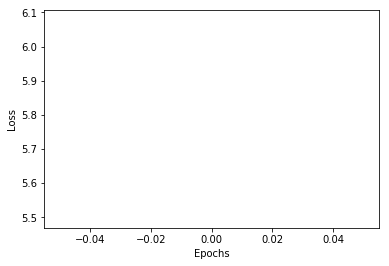

Testing Accuracy: 13.25


In [36]:
import numpy as np
import sys
import matplotlib.pyplot as plt

#Computes Matrix Multiplication
# Returns Z = A x W + b, cache
# A - nxd / n -> num of training data points
# W - dxd'/ d -> num of i/p features
# b - d'  / d'-> num of o/p features
# Z - nxd'
def Affine_Forward(A,W,b):
    Z = np.matmul(A,W)
    Z = Z+np.array([b]*A.shape[0])
    return Z,(A,W,b)

def Affine_Backwards(dZ,cache):
    A=cache[0]
    W=cache[1]
    b=cache[2]

    dA = np.zeros(A.shape)
    dW = np.zeros(W.shape)
    db = np.zeros(b.shape)

    W_T = W.transpose()
    dA=np.matmul(dZ,W_T)

    A_T = A.transpose()
    dW = np.matmul(A_T,dZ)

    for j in range(b.shape[0]):
        db[j]+=sum(dZ[:,j])

    return dA,dW,db

def ReLU_Forward(Z):
    Z_cache = np.array(Z)
    return np.maximum(Z,0,Z),Z_cache

def ReLU_Backward(dA,Z_cache):
    dZ = np.zeros(dA.shape)
    dZ = np.where(Z_cache>0.0,dA,0)
    return dZ

def Cross_Entropy(F,y):
    L_sub = 0
    n = F.shape[0]

    #print("y", y)
    for i in range(n):
        #print("F[i]",i, F[i])
        L_sub += F[i,int(y[i]-1)] - np.log(sum(np.exp(F[i])))

    L = -1.0/n * L_sub

    dF = np.zeros(F.shape)

    for i in range(F.shape[0]):
        for j in range(F.shape[1]):
            if(j==int(y[i])):
                match=1
            else:
                match=0
            if n ==0:
                print("N")
            if sum(np.exp(F[i])) == 0:
                #print("F", F)
                print("F[i]", F[i])
                #print("exp", np.exp(F[i]))
            
            dF[i,j] = -1.0/n*(match-(np.exp(F[i,j])/sum(np.exp(F[i]))))
    return L,dF

#Learning Rate
eta = 0.1
#NeuronCount at Layer1,2,3
Neurons=[64,8]
#Batch Size
b_size = 100
#Weights
W1 = []
W2 = []
#bias
b1 = []
b2 = []

#Four Layer Neural Net
#X      - input batch of n datapoints with d observations each
#W_all  - Weights for all 4 layers
#b_all  - bias for all 4 layers
#y      - training labels/correct actions
#test   - select Train/Test mode for network
def FourLvlNN(X,y,test,min_loss):
    global W1
    global W2
    
    global b1
    global b2

    Z1,cache_a1 = Affine_Forward(X,W1,b1)
    #print("Z1", Z1)
    #print("X", X)
    A1,cache_r1 = ReLU_Forward(Z1)
    #print("A1", A1)
    F,cache_a2  = Affine_Forward(A1,W2,b2)
    #print("F", F)

    if(test==True):
        classification = np.zeros((F.shape[0],))
        classification = np.argmax(F,axis=1)
        return classification
    
    loss,dF     = Cross_Entropy(F,y)
    #print("L", loss)
    #print("dF", dF)
    dA1,dW2,db2 = Affine_Backwards(dF,cache_a2)
    dZ1         = ReLU_Backward(dA1,cache_r1)
    #print("dZ1", dZ1)
    dX,dW1,db1  = Affine_Backwards(dZ1,cache_a1)

    if(loss<min_loss):
        min_loss=loss
        np.save("Weights.npy",np.asarray([W1,W2]))
        np.save("Bias.npy",np.asarray([b1,b2]))

    #Gradient Descent
    W1 = W1 - eta*dW1
    W2 = W2 - eta*dW2
    #print("1", dW1)
    #print("2", dW2)
    #print("3", dW3)

    return loss

def load_DataSet():
    data=np.loadtxt("expert_policy.txt")
    return data

#Initialize weights and biases
def bAndW_init(num_ip_features):
    global W1
    global W2
    
    global b1
    global b2

    W1 = np.random.uniform(0,0.8,(num_ip_features,Neurons[0]))
    W2 = np.random.uniform(0,0.8,(Neurons[0],Neurons[1]))
    
    b1 = np.zeros((Neurons[0],))
    b2 = np.zeros((Neurons[1],))
'''
All data in dataset already normalized
def normalize(X):
    data = X.copy()
    for feature in data:
        mean = np.mean(feature)
        std = np.std(feature)
        feature -= mean
        feature /= std
    #print("D",data)
    #print("X",X)
    return data

def normalize_dataset(data):
    for feature in range(len(data)-1):
        mean = np.mean(data[feature])
        std = np.std(data[feature])
        data[feature] -= mean
        data[feature] /= std
    return data
'''
def MiniBatchGD(data,epoch):
    global W1
    global W2
    
    global b1
    global b2
    print("Running MiniBatchGCD with",epoch,"epochs\n")
    num_ip_features = data.shape[1]-1
    #Global score for 'b's and 'W's
    bAndW_init(num_ip_features)

    loss_list=[]
    min_loss = 100

    for cycle in range(epoch):
        np.random.shuffle(data)
        for i in range(data.shape[0]//b_size):
            #displayProgess(i,data.shape[0]//b_size)
            X = data[i*b_size:(i+1)*b_size,:-1]
            #print("X",X)
            #X = normalize(X)
            y = data[i*b_size:(i+1)*b_size,-1]
            loss = FourLvlNN(X,y,False,min_loss)
        print("\nEpoch",cycle,"Loss",loss,"\n")
        loss_list.append(loss)

    np.save("LossCurve.npy",np.asarray(loss_list))

def evaluateAccuracy(data):
    global W1
    global W2
    
    global b1
    global b2

    W_all = np.load("Weights.npy")
    b_all = np.load("Bias.npy")
    W1 = W_all[0]
    W2 = W_all[1]
    b1 = b_all[0]
    b2 = b_all[1]

    X = data[:,:-1]
    y = data[:,-1]
    classifications =FourLvlNN(X,y,True,-1)
    correct=0
    for i in range(len(y)):
        if(classifications[i]==int(y[i])):
            correct+=1
    accuracy = correct/len(y)*100
    print("Testing Accuracy:",accuracy)

def displayLossCurve():
    loss_array=np.load("LossCurve.npy")
    plt.plot(loss_array)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

def displayProgess(i,N):
    sys.stdout.write('\r')
    sys.stdout.write("Batch %d/%d in progress"%(i+1,N))
    bars = int((i/N*100)//10)
    sys.stdout.write(" [%-10s]"%('='*bars+'>',))

def main():
    nn_db = pd.concat([rand_db, target], axis=1)
    data = nn_db.as_matrix()
    MiniBatchGD(data,10)
    displayLossCurve()
    evaluateAccuracy(data)

main()